## 📘 **Applications of Explainable AI in Predictive Modelling**  
---

🏫 Week 10   
📅 Date: 2025-04-29  
🧑‍🏫 Irena Zimovska

---



## **Load libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LearningCurveDisplay

import seaborn as sns
# from xgboost import XGBRegressor

import joblib


## **Load data**

In [5]:
# Load the prepared train and test data
X_train = pd.read_csv("../data/processed/X_train_data.csv")
X_test = pd.read_csv("../data/processed/X_test_data.csv")
y_train = pd.read_csv("../data/processed/y_train_data.csv")
y_test = pd.read_csv("../data/processed/y_test_data.csv")

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape :", X_test.shape, y_test.shape)


Train set shape: (15005, 21) (15005, 1)
Test set shape : (6431, 21) (6431, 1)


In [6]:
X_train["m2_ratio"] = X_train["m2_above"]/(X_train["m2_basement"]+0.1)
X_test["m2_ratio"] = X_test["m2_above"]/(X_test["m2_basement"]+0.1)

# Omitting zipcode 
X_train = X_train.drop(["zipcode", "m2_basement", "m2_above", "since_renovated"], axis=1)
X_test = X_test.drop(["zipcode", "m2_basement", "m2_above", "since_renovated"], axis=1)

In [7]:
# Separate training samples with coordinates and district names 

common_features = [col for col in X_train.columns if col not in ['lat', 'long', 'district_name']]

preprocessor_coords = ColumnTransformer([
    ('coords', 'passthrough', ['lat', 'long']), 
    ('common', 'passthrough', common_features)
], remainder='drop')


preprocessor_district = ColumnTransformer([
    ('district', OneHotEncoder(drop='first', handle_unknown='ignore'), ['district_name']), 
    ('common', 'passthrough', common_features)
], remainder='drop')

In [8]:
strategies = {
    'coords': preprocessor_coords, 
    'district': preprocessor_district
}

## 🔍 **Ensemble Learning: the Wisdom of the Crowd**

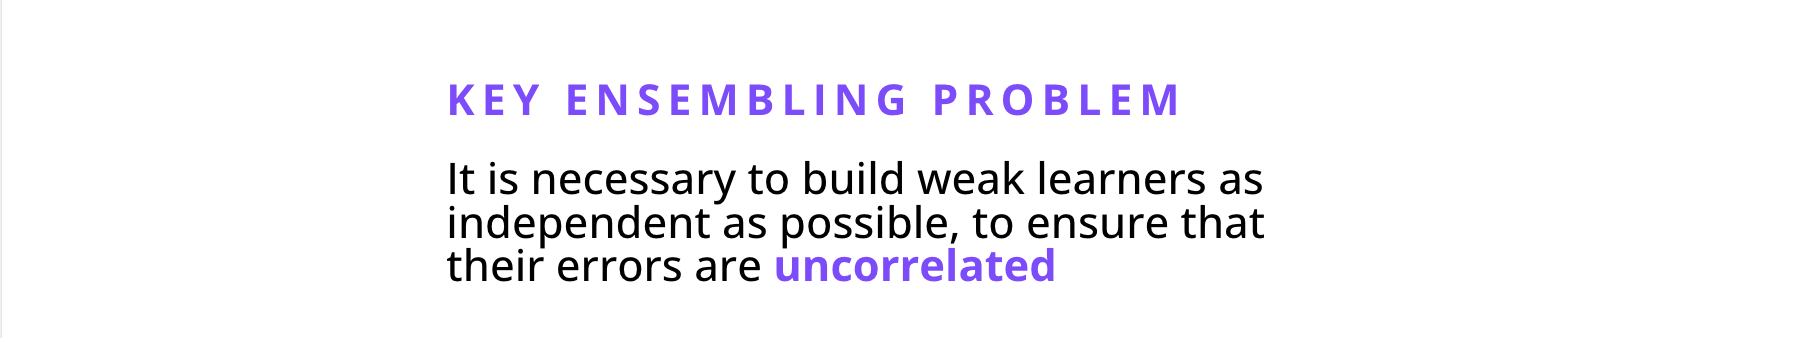

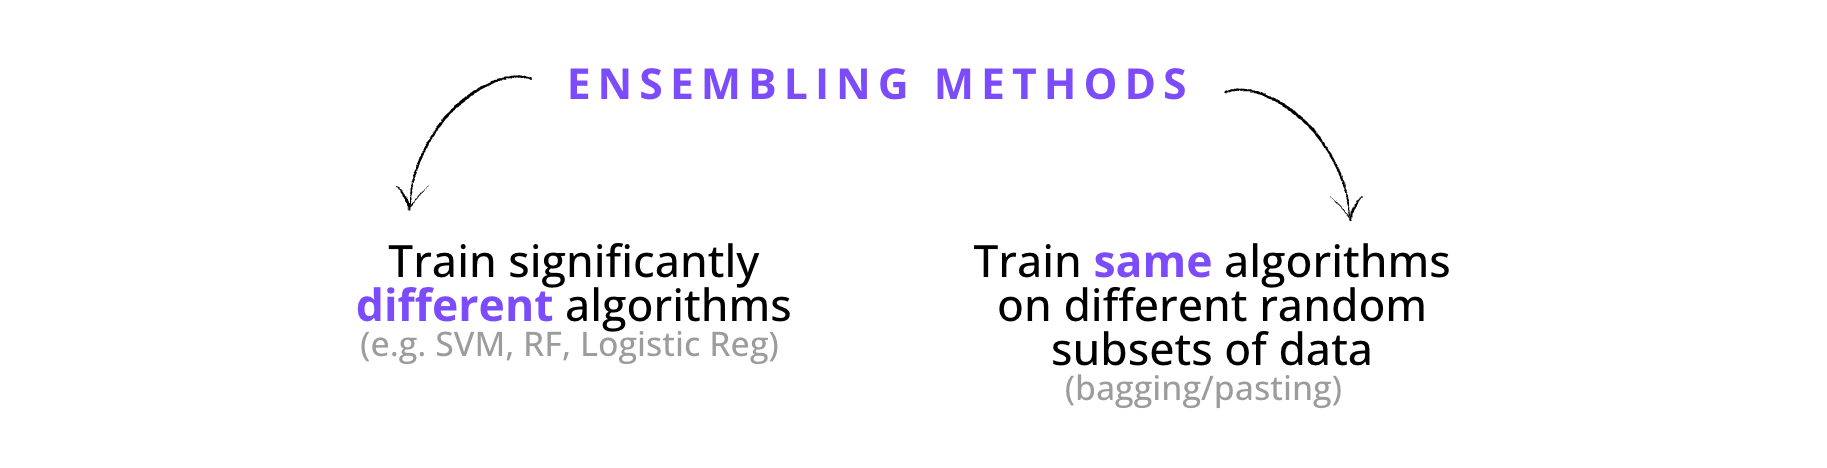

> **Bagging (bootstrap aggregating)** - Training by sampling with replacement (observations can be sampled several times for the same predictor)

> **Pasting** - Training by sampling without replacement

## 🚀 **Random Forests: Bagging with Decision Trees**
Random Forest is an ensemble of Decision Trees, generally
trained via the **bagging** method (or sometimes pasting), typically with `max_samples`
set to the size of the training set.

The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression.

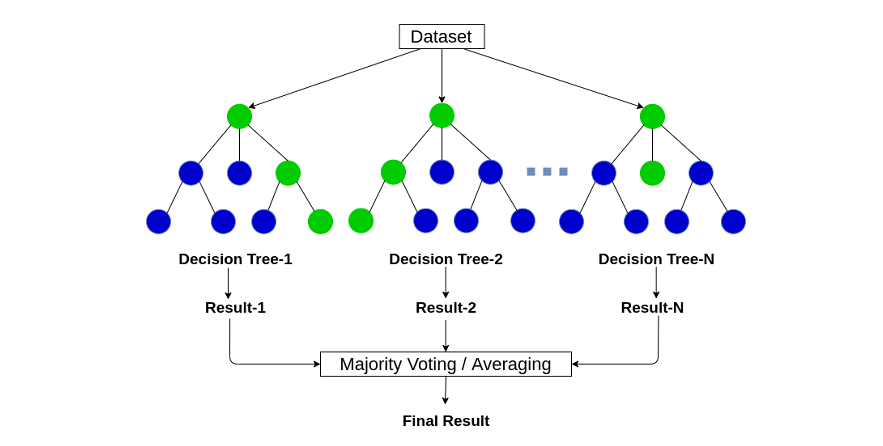


`RandomForestRegressor` and `RandomForestClassifier` obtain all the hyperparameters of the Decision Trees together with `BaggingClassifier`.


In [9]:
pipeline_rf = Pipeline([
    ('preprocess', strategies['coords']),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))
])

pipeline_rf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('coords', 'passthrough',
                                                  ['lat', 'long']),
                                                 ('common', 'passthrough',
                                                  ['bathrooms', 'bedrooms',
                                                   'floors', 'waterfront',
                                                   'view', 'condition', 'grade',
                                                   'dist_stop', 'ncult', 'age',
                                                   'm2_living', 'm2_lot',
                                                   'm2_living15', 'm2_lot15',
                                                   'm2_ratio'])])),
                ('model', RandomForestRegressor(max_depth=3, n_jobs=-1))])

In [10]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits=5, shuffle=True, random_state=42)


rf_cv_scores = cross_val_score(pipeline_rf, X_train, y_train.values.ravel(),
                               cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)

# Convert negative MSE to RMSE.
rf_rmse_scores = np.sqrt(-rf_cv_scores)

print("Cross-validated RMSE scores for Random Forest Regression:", rf_rmse_scores)
print("Mean CV RMSE:", rf_rmse_scores.mean())

Cross-validated RMSE scores for Random Forest Regression: [0.27921972 0.29301876 0.29283653 0.29738453 0.28652771]
Mean CV RMSE: 0.28979744921333717


### 🚀 **Random Forest Advantages**

- **Lower risk of overfitting out-of-the-box**

For each tree, only a fraction of features are used for each tree and only a subsample of data.

- **Built in Feature Importance** 

We can rank features based on how much they reduce the error cost function. The more, the better (see the figure below). This is easily done because the reduction for each feature is calculated during the model fitting. This feature importance method is not ideal, but since it comes for free, you can use it out of the box. This allows you to quickly identify if your ML model's feature importance makes sense in general. And which features are good predictors for the target.

- **No feature scaling is needed**


### 🔍 **Random Forest Hyperparameters** 

**Controlling Overfitting / Underfitting**

| Hyperparameter         | Purpose                                         | Typical Range          | Notes |
|:------------------------|:------------------------------------------------|:------------------------|:------|
| `n_estimators`          | Number of trees in the forest                   | 100–2000+               | More trees → better performance but slower training. |
| `max_depth`             | Maximum depth of each tree                     | 5–30+ (or `None`)       | Too shallow → underfit, too deep → overfit. |
| `min_samples_split`     | Minimum samples required to split a node       | 50–500 (if large leaves) | Higher values = more regularization. |
| `min_samples_leaf`      | Minimum samples at a leaf node                 | 100–500 (large datasets) | Controls smoothing and regularization. |
| `max_leaf_nodes`        | Maximum number of leaf nodes                   | 10–1000                 | Explicit limit on tree complexity. |

---

**Reducing Variance (Making Trees More Different)**

| Hyperparameter         | Purpose                                         | Typical Range          | Notes |
|:------------------------|:------------------------------------------------|:------------------------|:------|
| `max_features`          | Fraction/features considered per split         | `sqrt`, `log2`, 0.3–1.0 | Smaller = more randomness → more diverse trees. |
| `bootstrap`             | Whether to perform bootstrap sampling        | `True` or `False`       | True = bagging (classical RF), False = pasting. |
| `oob_score`             | Use out-of-bag samples for validation        | `True` or `False`       | Monitors generalization without CV split. |
| `max_samples`           | Fraction of samples used           | 0.5–1.0                 | Useful for controlling training set size. |

---

**Performance and reproducibility**

| Hyperparameter         | Purpose                                         | Typical Range          | Notes |
|:------------------------|:------------------------------------------------|:------------------------|:------|
| `n_jobs`                | Number of CPU cores to use                     | `-1` or specific int    | Always `-1` for full parallelization. |
| `random_state`          | Random seed                                    | Integer                 | Ensures reproducibility across experiments. |

---


## 🔍 **Hyperparameter optimisation: the recap**

| Method                 | Description                                                                 | Pros                                              | Cons                                              |
|-------------------------|-----------------------------------------------------------------------------|---------------------------------------------------|---------------------------------------------------|
| **Grid Search**         | Evaluates a fixed set of points on a grid.                                  | Simple to understand and implement.               | Expensive in high dimensions, can miss optimum.   |
| **Random Search**       | Samples points randomly across the search space.                           | Often better than grid in high dimensions.         | No guarantee to sample near optimum.              |
| **Bayesian Optimization** | Models the objective function using a surrogate (like Gaussian Process) and chooses next points based on uncertainty. | Efficient, finds good solutions with fewer trials.| More complex, slower per iteration, tuning needed. |



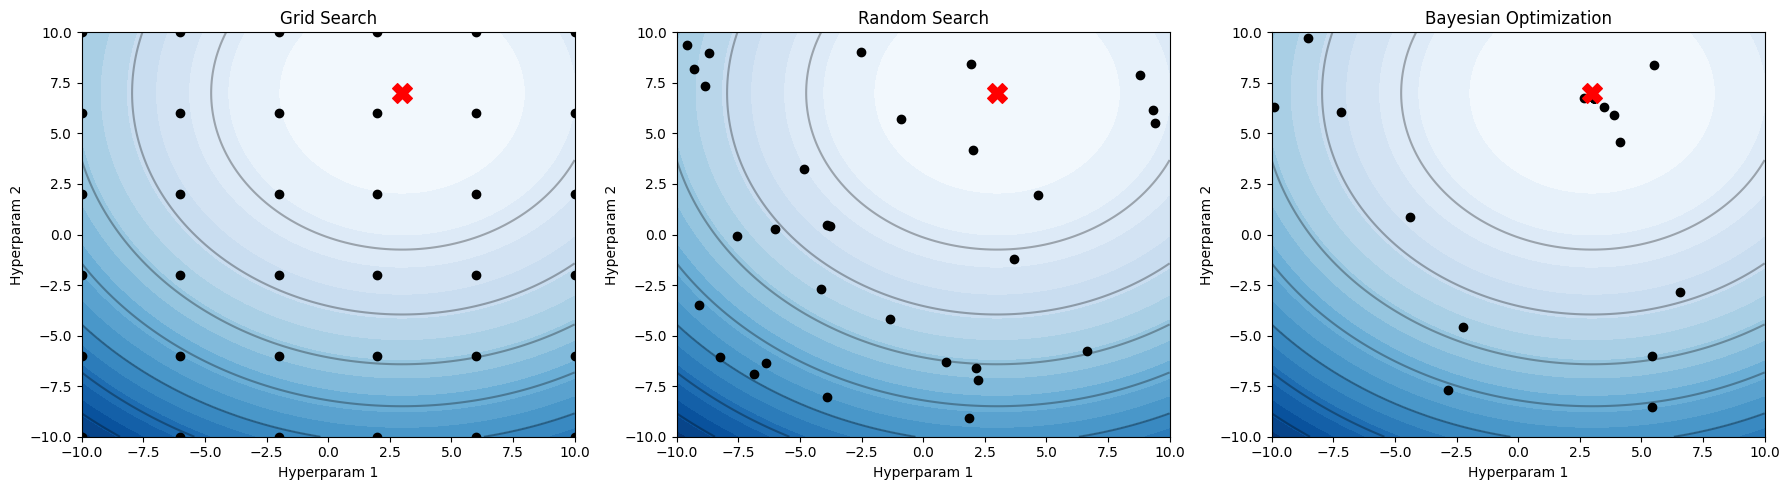


#### **Bayesian Optimisation** 

- Randomly sample a small number (e.g. 5–10) of hyperparameter combinations and evaluate each by running your pipeline with cross-validation to get a validation score.

- Fit a **surrogate model** (usually a Gaussian Process or Tree-structured Parzen Estimator) that maps hyperparameter settings → predicted validation performance.

- Use an **acquisition function** (e.g. Expected Improvement, Upper Confidence Bound) on the surrogate to suggest the next hyperparameter set by balancing **exploration** (trying under-sampled regions) and **exploitation** (refining around known good settings)

- Evaluate the suggested hyperparameters with the true objective (cross-validation score) and add this result to your dataset.

- Update the surrogate model with the new point and repeat the acquisition.

Resources: 

- GaussianProcessRegressor in Scikit-Learn: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

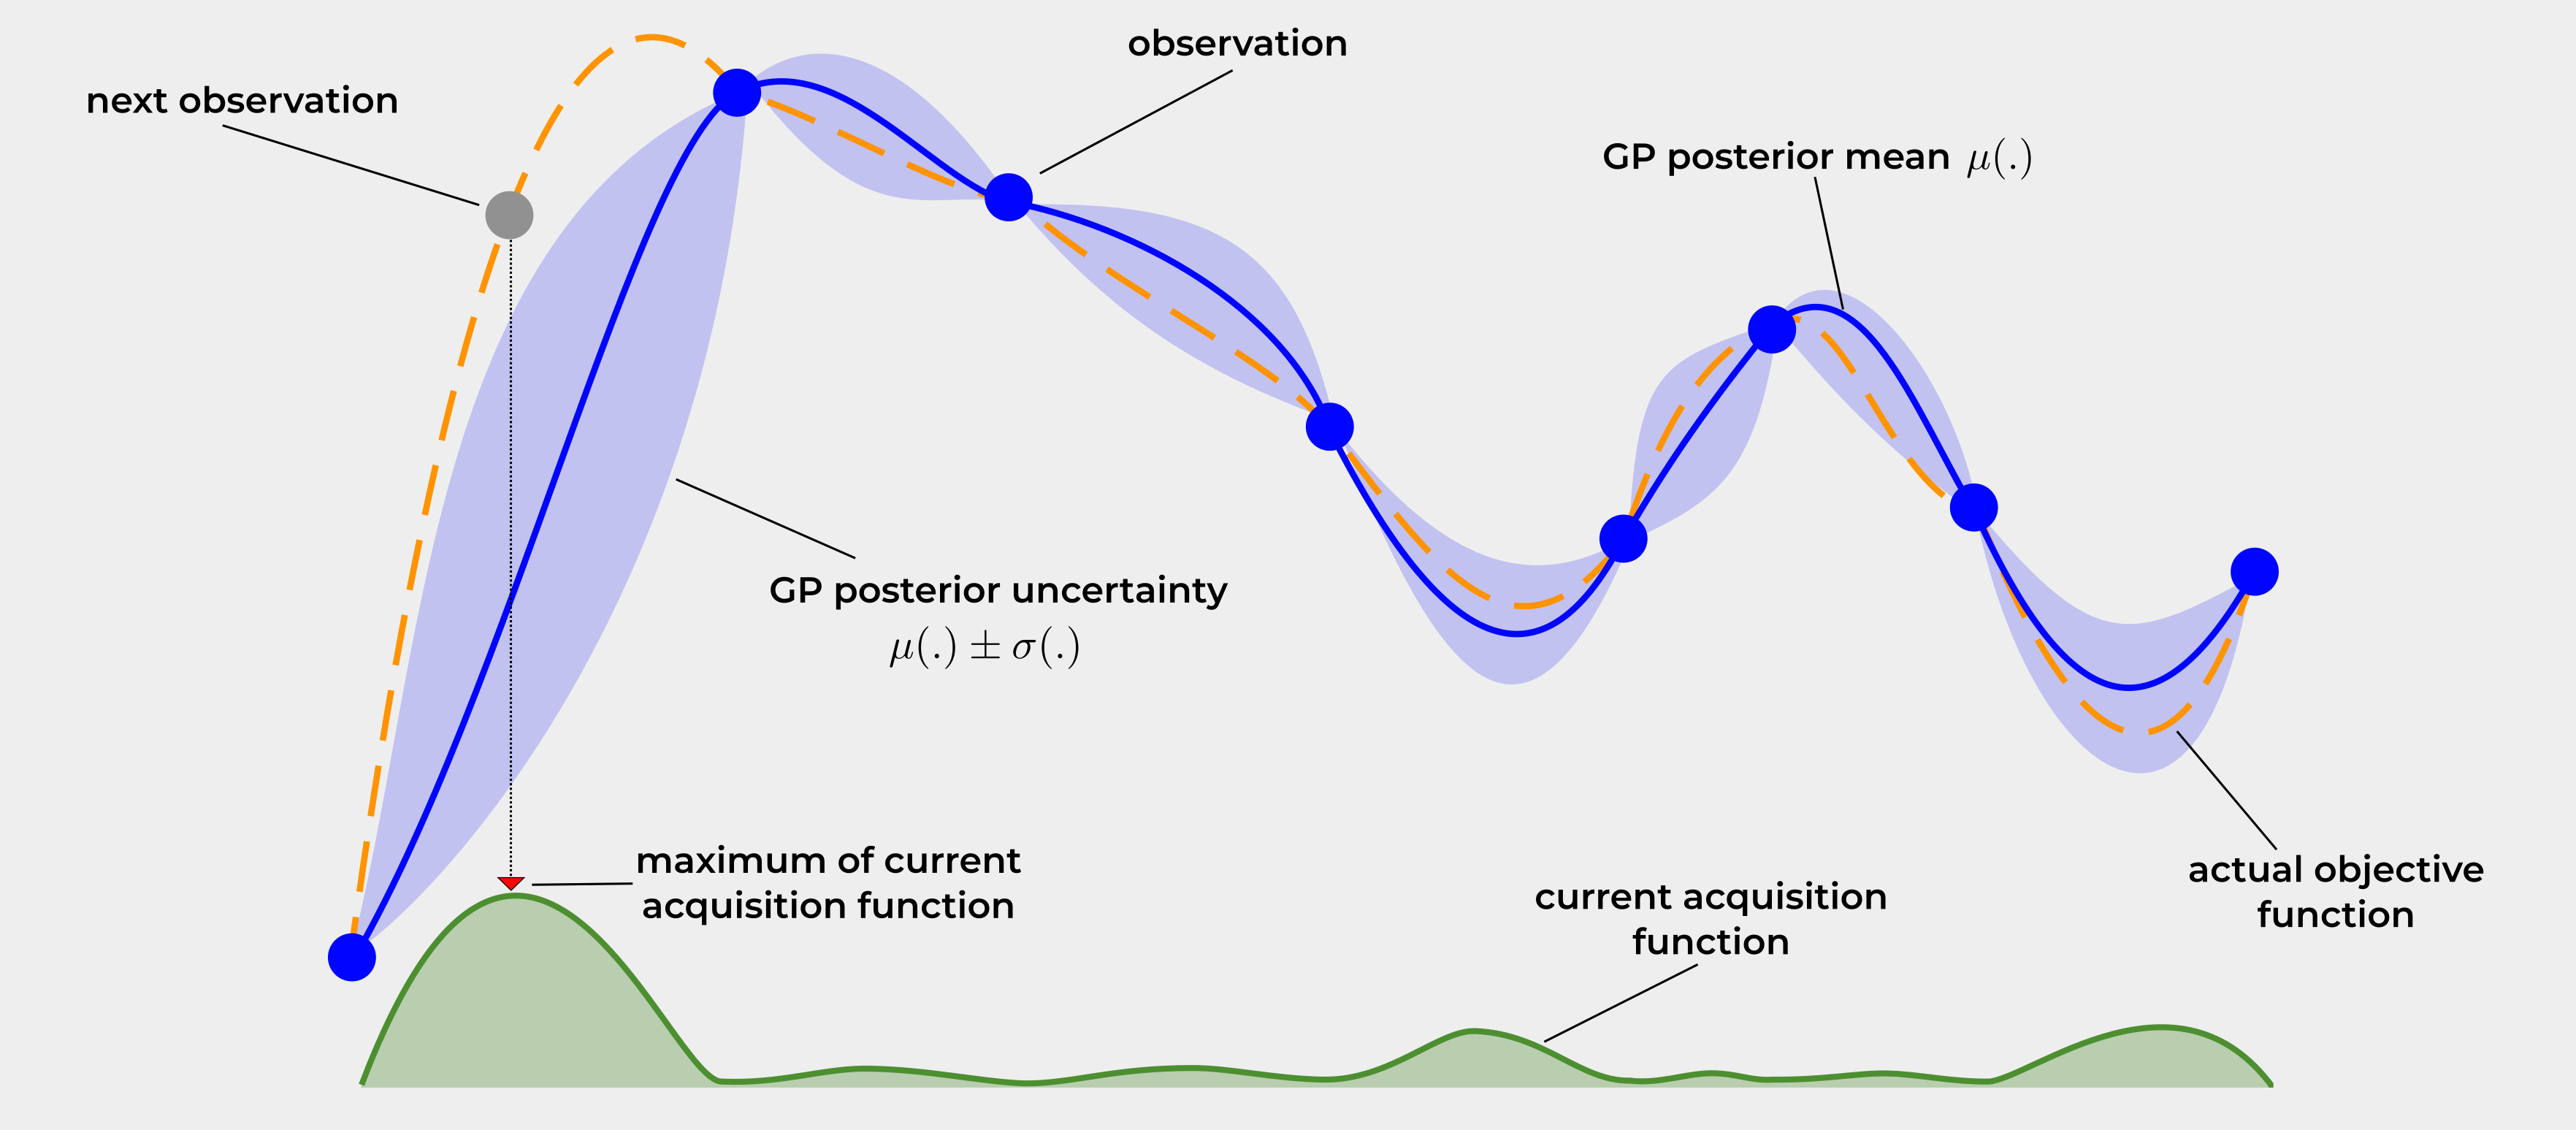

Source: https://firasalhafez.com/2021/05/12/finding-the-optimal-learning-rate-using-bayesian-optimization/

## 🚀 **Hyperparameter tuning with Optuna**


Usefull resources: 

- Documentation: https://optuna.readthedocs.io/en/stable/index.html

- Bayesian Optimisation break down with Optuna: https://medium.com/optuna/optuna-v4-2-gaussian-process-based-sampler-can-now-handle-inequality-constraints-a4f68e8ee810

In [16]:
import optuna 
from optuna.samplers import TPESampler
optuna.__version__

'4.3.0'

To run the optimization in optuna you need: 

1) the **objective** function which is to be optimized (i.e maximized or minimized)
2) the **study** - the object for the process of optimzing an objective function. It aims to find the best configuration.

A **trial** is a single execution of the objective function. In our case, the training and evaluation of the model using the chosen hyperparameters.

In [11]:
# Define objective function - what is to be optimized?
def make_objective(preprocessor): 
    def objective(trial): 
        """
        Define a search space for the hyperparameters `n_estimators` and `max_depth`
        of a random forest model, then train and evaluate it using cross validation.
        """
        
        # Define hyperparameters to tune 
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 100, 1000, step=100),
            'max_depth': trial.suggest_int("max_depth", 2, 6),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 100, 1000),
            'max_features': trial.suggest_float("max_features", 0.3, 1.0), 
            'bootstrap': trial.suggest_categorical("bootstrap", [True, False]),
            'random_state': 42,
            'n_jobs': -1
        }

        # If data is not bootstrapped, we can allow tuning max_samples
        if params['bootstrap']==True:
            params['max_samples'] = trial.suggest_float("max_samples", 0.5, 1.0)
            
        pipeline_rf = Pipeline([
            ('preprocess', preprocessor),
            ('model', RandomForestRegressor(**params))
            ])

        pipeline_rf.fit(X_train, y_train.values.ravel())

        mse_scores = cross_val_score(
            estimator=pipeline_rf,
            X=X_train, 
            y=y_train.values.ravel(), 
            cv=KFold(n_splits=5, shuffle=True, random_state=42), 
            scoring="neg_mean_squared_error", 
            n_jobs=-1
            )
        
        rmse_score = np.sqrt(-mse_scores).mean()
            
        return rmse_score

    return objective

In [10]:
# Create and run the Optuna "Study"
for name, preprocessor in strategies.items(): 
    study=optuna.create_study(direction="minimize", sampler=TPESampler(seed=89))
    study.optimize(make_objective(preprocessor=preprocessor), n_trials=100)

    joblib.dump(study, f"../models/study_rf_{name}.pkl")

[I 2025-04-29 12:39:04,139] A new study created in memory with name: no-name-66df8f8b-422c-44b5-b8e7-7ecc5dc62db4
[I 2025-04-29 12:39:06,376] Trial 0 finished with value: 0.290775098019745 and parameters: {'n_estimators': 500, 'max_depth': 3, 'min_samples_leaf': 332, 'max_features': 0.3678451966074149, 'bootstrap': True, 'max_samples': 0.5762976144419594}. Best is trial 0 with value: 0.290775098019745.
[I 2025-04-29 12:39:09,755] Trial 1 finished with value: 0.32637148167186086 and parameters: {'n_estimators': 500, 'max_depth': 2, 'min_samples_leaf': 475, 'max_features': 0.9395555694242763, 'bootstrap': True, 'max_samples': 0.8563041952510919}. Best is trial 0 with value: 0.290775098019745.
[I 2025-04-29 12:39:11,117] Trial 2 finished with value: 0.3001538938694411 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_leaf': 699, 'max_features': 0.3968515597431299, 'bootstrap': True, 'max_samples': 0.7938957772241131}. Best is trial 0 with value: 0.290775098019745.
[I 2025

##### **Dump the optuna study objects**

In [12]:
# Load the study 
study_rf_coords = joblib.load("../models/study_rf_coords.pkl")
study_rf_district = joblib.load("../models/study_rf_district.pkl")

##### **Check the best parameters for RF**

In [13]:
print(f"Best set of parameters for RF with coordinates: {study_rf_coords.best_params}")
print(f"Best set of parameters for RF with district names: {study_rf_district.best_params}")

Best set of parameters for RF with coordinates: {'n_estimators': 700, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': 0.6339463481492791, 'bootstrap': True, 'max_samples': 0.8974470966912341}
Best set of parameters for RF with district names: {'n_estimators': 900, 'max_depth': 6, 'min_samples_leaf': 101, 'max_features': 0.677327435315308, 'bootstrap': False}


##### **Compare RF best models RMSE**

In [14]:
print(f"Best RMSE on train data with CV for RF with coordinates: {study_rf_coords.best_value}")
print(f"Best RMSE on train data with CV for RF with district names: {study_rf_district.best_value}")

Best RMSE on train data with CV for RF with coordinates: 0.2263227311846699
Best RMSE on train data with CV for RF with district names: 0.28511769822692556


##### **Visualise the tuning paths**

In [21]:
# What parameters where the most important?
# optuna.visualization.plot_param_importances(study_rf_coords)

# Visualise the optimisation process 
# A good option to demonstrate whether the optimisation process is converging, e.g.b whether you still need more trials? 
# optuna.visualization.plot_optimization_history(study_rf_coords)

optuna.visualization.plot_slice(study_rf_coords)

# optuna.visualization.plot_parallel_coordinate(study_rf_coords)

##### **Fit the best models and dump**

In [22]:
pipeline_rf_coords = Pipeline([
    ('preprocess', strategies['coords']), 
    ('model', RandomForestRegressor(**study_rf_coords.best_params, random_state=42, n_jobs=-1))
])

pipeline_rf_coords.fit(X_train, y_train.values.ravel())

# Dump the Forest 
joblib.dump(pipeline_rf_coords, "../models/random_forest_coords.joblib")

['../models/random_forest_coords.joblib']

In [23]:
pipeline_rf_district = Pipeline([
    ('preprocess', strategies['district']), 
    ('model', RandomForestRegressor(**study_rf_district.best_params, random_state=42, n_jobs=-1))
])

pipeline_rf_district.fit(X_train, y_train.values.ravel())

# Dump the Forest 
joblib.dump(pipeline_rf_district, "../models/random_forest_district.joblib")

['../models/random_forest_district.joblib']

##### **Check the learning curves**

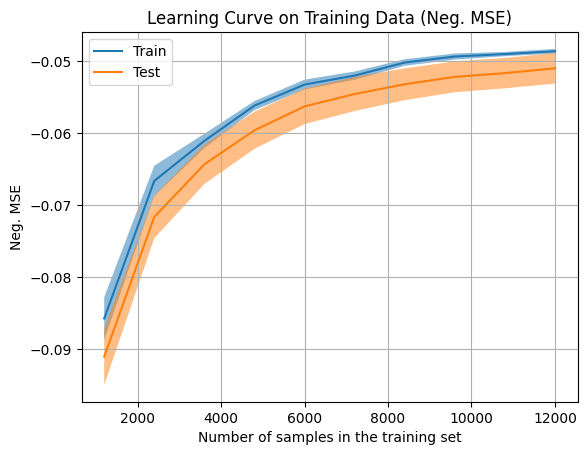

In [17]:
# Learning curve on training data
LearningCurveDisplay.from_estimator(
    pipeline_rf_coords,
    X_train, y_train.values.ravel(),
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    score_name="Neg. MSE"
)

plt.title("Learning Curve on Training Data (Neg. MSE)")
plt.grid()
plt.show()


## 🚀 **Gradient Boosting**

#### Controlling Overfitting / Underfitting

| Hyperparameter      | Purpose                                                         | Typical Range     | Notes                                                                                   |
|:--------------------|:----------------------------------------------------------------|:------------------|:----------------------------------------------------------------------------------------|
| `n_estimators`      | Number of boosting rounds (trees)                               | 100–1000+         | More trees → better fit but longer training, risk of overfitting if too many.          |
| `learning_rate`     | Step-size shrinkage (`eta`)                                     | 0.01–0.3          | Smaller → slower learning, needs more trees but often yields better generalization.     |
| `max_depth`         | Maximum depth of each tree                                      | 3–10              | Too shallow → underfit; too deep → overfit.                                            |
| `min_child_weight`  | Minimum sum of instance weight (Hessian) in a child             | 1–10              | Larger → more conservative splits, reduces overfitting.                                 |
| `gamma`             | Minimum loss reduction required to make a split                  | 0–5               | Higher → fewer splits, more conservative tree growth.                                   |

#### Reducing Variance (Making Trees More Different)

| Hyperparameter     | Purpose                                                        | Typical Range | Notes                                                     |
|:-------------------|:---------------------------------------------------------------|:--------------|:----------------------------------------------------------|
| `subsample`        | Fraction of rows sampled for each tree                         | 0.5–1.0       | Lower → more randomness, reduces correlation among trees. |
| `colsample_bytree` | Fraction of features sampled per tree                          | 0.5–1.0       | Like RF’s `max_features`; smaller → more diverse trees.   |


#### Performance & Reproducibility

| Hyperparameter  | Purpose                                                         | Typical Range              | Notes                                              |
|:----------------|:----------------------------------------------------------------|:---------------------------|:---------------------------------------------------|
| `n_jobs`        | Number of parallel threads                                      | `-1` or int                | `-1` uses all cores—speeds up training.             |
| `random_state`  | Seed for RNG                                                    | Integer                    | Ensures experiment reproducibility.                |
| `objective`     | Learning task and loss function                                 | e.g. `reg:squarederror`    | Must match your problem type (regression/classification). |


**Tips for tuning XGboost** 

- Take into account that `learning_rate`, `tree_depth`, `number of threes` parameters are highly related
- Pick up only ONE regularization approach L2 or L1 (the difference between those was discussed in previous class)
- Don't forget to use cross-validation 


##### **Load the optuna study objects**

In [25]:
# Load the study 
study_xgb_coords = joblib.load("../models/study_xgb_coords.pkl")
study_xgb_district = joblib.load("../models/study_xgb_district.pkl")

##### **Compare XGB best models RMSE**

In [27]:
print(f"Best RMSE on train data with CV for XGB with coordinates: {study_xgb_coords.best_value}")
print(f"Best RMSE on train data with CV for XGB with district names: {study_xgb_district.best_value}")

Best RMSE on train data with CV for XGB with coordinates: 0.16103045970843993
Best RMSE on train data with CV for XGB with district names: 0.21871988525295313


## 🚀 **Model Evaluation**

In [28]:
model_files = {
    'LR Districts': '../models/linear_regression_pipeline.joblib',
    'DT Districts': '../models/decision_tree_pipeline.joblib',
    'RF Coords': '../models/random_forest_coords.joblib',
    'RF Districts': '../models/random_forest_district.joblib',
    'XGB Coords':   '../models/xgboost_coords.joblib',
    'XGB District': '../models/xgboost_district.joblib'
}

models = {name: joblib.load(path) for name, path in model_files.items()}

In [30]:
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, mdl in models.items():
    neg_mses = cross_val_score(
        mdl, X_train, y_train.values.ravel(),
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_train = np.sqrt(-neg_mses).mean()
    
    y_pred = mdl.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({'model': name, 'rmse_train': rmse_train, 'rmse_test': rmse_test})

In [31]:
df_results = pd.DataFrame(results)
df_results

,model,rmse_train,rmse_test
0,LR Districts,0.223837,0.251516
1,DT Districts,0.277890,0.322898
2,RF Coords,0.226323,0.223646
3,RF Districts,0.285118,0.280759
4,XGB Coords,0.161030,0.158779
5,XGB District,0.218720,0.218446


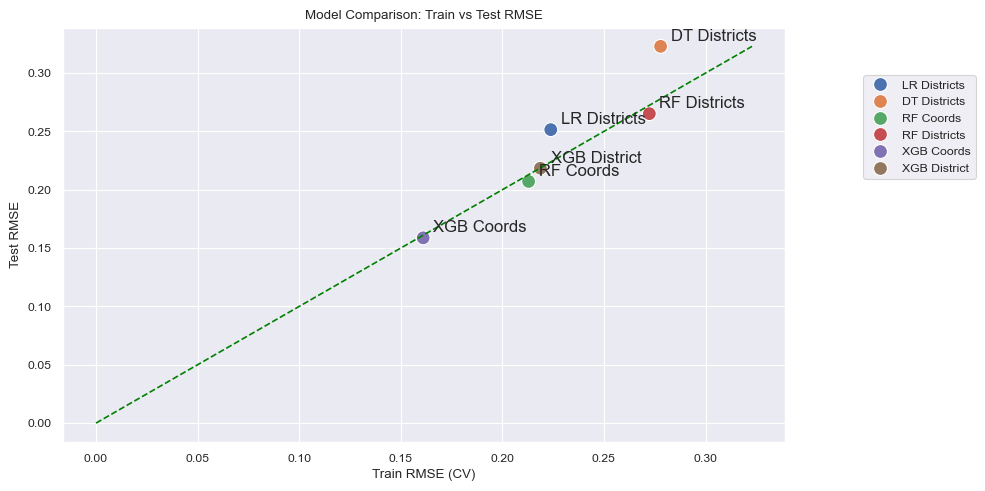

In [ ]:
sns.set_style(style='darkgrid')
sns.set_context("paper")
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(data=df_results,
                     x='rmse_train', y='rmse_test',
                     hue='model', 
                     s=100)

g = max(df_results['rmse_train'].max(), df_results['rmse_test'].max())
ax.plot([0, g], [0, g], '--', color='green')


for idx, row in df_results.iterrows():
    ax.text(row['rmse_train'] + 0.005, row['rmse_test'] + 0.005,
            row['model'], fontsize=12)

ax.set_xlabel('Train RMSE (CV)')
ax.set_ylabel('Test RMSE')
ax.set_title('Model Comparison: Train vs Test RMSE')
plt.legend(bbox_to_anchor=(1.1, 0.9), loc='upper left')
plt.tight_layout()
plt.show()


## 🚀 **Homework Task: Leverage Optuna for Gradient Boosting**

**Task 1** *(2 points + 1 extra point for beating my result)*

Tune the hyperparameters of the XGBoost model to achieve the best possible result and answer the following questions:

- Which hyperparameters had the greatest impact on the performance?  
- Describe the relationships between the objective (RMSE) and the hyperparameters.  
- How quickly did the optimization converge to the best result?

---

**Task 2**

*2 points*

Compare Random Search with Bayesian hyperparameter optimization. Under the same number of trials, which algorithm achieves a better result?

*1 point*

The number of trials may influence the accuracy of the search algorithms.  
Evaluate the models with different numbers of trials and visualize the convergence paths.  
Which algorithm converges to the best solution faster?
